# golive2

## Introduction

### Data summary

The notebook continues the **golive** narrative on valley glacier speed in southeast Alaska, 
centered around the Malaspina/Seward/Columbus/Bagley/Bering glacier complex.
**golive2** increases the data volume from 50 to 300 results; still for just a single
LANDSAT-8 frame (Path 63 Row 18).
The time range is 2013 day 111 (April 21) through June 2019, over 6 years.
Mean time spacing is at best about eight days between observations.

This notebook and subsequent ones aspire to...

- a very complete ice motion map using mean values
- variance maps: v(T)/v(mean) as time sequence
- ...and additional analysis
- multiple L8 frames within a single UTM zone
- another region (Himalayas; S43 or T43)

Related questions

- What complementary datasets are available? 
  - Ice thickness? 
  - Surface elevations?
    - as these are available: various dynamic calculations are poosible
      - volume advection estimates / flux gate views
      - sliding speed variability, bed implications

- How to share related synthesized datasets?
  - for example a regularly time-sampled grid of ice speed
  - data reduction results such as windowed standard deviation or (std / mean)
  - Does masking clarify results e.g. by checking velocity direction agreement, invoking `lgo_mask` etc 
    - lgo_mask varies slightly from one result to the next
    - some pixels have unrealistically high velocities (noise)
  - What does 2013 speed / mean speed look like? (2013 shows as higher speed on Seward Glacier)



### Methods 


The source data (speed fields from Landsat 8 image pairs) are stored as NetCDF files.
Here the `xarray.open_mfdataset()` 'open multiple-file dataset' treats the
entire time series as a single xarray Dataset. Spatial bounds expand to encompass
all of the source data. 


The ice speed scalar field is defined everywhere but meaningful only where the processing
algorithm finds a proper correlation. Bad results include high speeds, motion in the wrong
direction, `-9999.` and `nan` values, etcetera.
`nan` is what we want as this works with `.mean()` and `std()`. 


Within this Dataset the DataArray **Data variable** objects include
both scalar speed `vv_masked` and the land/glacier/ocean mask `lgo_mask`. The latter has
values at each pixel of 0, 1 or 2 for glacier, land and ocean respectively. The mask can
be used to filter speed. Mask values may vary between 0 and 1 from one 
result to another in the steep terrain of this region.


The time-slice data files can be seen along the time axis without loading the data into
memory. However this means that time-series analysis across the entire scene will have 
unacceptable latency as files are repeatedly opened and closed. The `xarray.Dataset.load()` 
method circumvents this by reading the DataArray into memory whereupon latency drops to 
negligible. 



## Part 1. Data loader

* Consolidate a large collection of data files into a single Dataset
* load certain DataArrays into memory: the `.load()` method

In [1]:
%matplotlib inline

!pip install utm
!pip install pygeotools

import timeit
from datetime import timedelta, datetime
from matplotlib import pyplot as plt
import pandas as pd
import netCDF4
import xarray as xr
import dask
import numpy as np
from numpy import datetime64 as dt64, timedelta64 as td64
from scipy import stats
from scipy.signal import medfilt as mf
from random import randint as ri
from ftplib import FTP

from ipywidgets import *                # interactivity
from traitlets import dlink             # interactivity
import sys
import os
import utm

# from osgeo import gdal 
# from pygeotools.lib import iolib,timelib

import golive_utility as g

In [5]:
# file grabbing code... this takes a few minutes 
# 
# Running it June 13 2019 pulled 241 files in addition to the 52 files pulled by the golive (preceding) notebook
#   for a total of 293 "looks" at glacier speed from April 2013 to June 2019.
#
# As before this code is turned 'off' by default so it is only run intentionally

# because the files are redundant: Use the data directory for the golive3 as the source 
golive_big_d = g.SetDataDirectory('golive_big')

if False:
    ftp = FTP('dtn.rc.colorado.edu')
    ftp.login()
    ftp.cwd('work/nsidc0710/nsidc0710_landsat8_golive_ice_velocity_v1.1/p063_r018')
    a=[]
    ftp.dir(a.append)    # This is a rather tricky line of Python as it passes an append method as an argument
    d = [b.split()[8] for b in a if \
                 len(b.split()) == 9 and \
                 b.split()[8][-3:]=='.nc' and \
                 b.split()[8][11:14]!='016'
        ]
    for i in range(len(d)):
        ftp.retrbinary('RETR ' + d[i], open(golive2_d + d[i], 'wb').write)  
        print('obtained file', i)
    ftp.quit()
    print(len(d))
    # for c in d: print(c)

In [8]:
%%time

# Here the cell magic %%time call must happen as the first line of the cell with no additional characters.
# 300 files on the pangeo Jupyter Hub required 10 minutes to complete. 

# Now we do things the modern way with xarray Datasets: All of these data files will be registered into a
#   *single* Dataset. Obviously this massive dataset will have an added index corresponding to time. Let's
#   observe an issue there before proceeding to the mechanics of the Dataset.
#
# To wit: Some 16-day and 48-day interval L8 pairs can have the same center time... so we accumulate these center
#   times as timestamps in a list tslist[]. When a redundancy happens: Add an hour to the new one so it does not
#   appear simultaneous with the former. Otherwise it is an error in the Dataset compilation.
# 
# The xarray method of interest is 'open multi-file dataset': .open_mfdataset(). In order for these multi-hundred
#   files to sort they need a sortable dimension; which in this case is time. Specifically the mid_date parameter
#   which is half way between first and second LANDSAT image acquisition. The preprocessor method 'pp' invoked
#   by open_mfdataset is the key to this sorting process. 

tslist = []

def pp(ds):
    global tslist
    s = ds['image_pair_times'].attrs['mid_date']
    ts = pd.Timestamp(s)
    while ts in tslist: ts += timedelta(hours = 1)
    tslist.append(ts)
    # verify that everything is moving: print(len(tslist), ts)
    ds['time'] = xr.Variable('time', [ts])
    return ds

# Since a 'time' dimension is added in preprocessing: It can be used as the ordering dimension here
m = xr.open_mfdataset(golive_big_d + 'L8_063_018_096*.nc', preprocess = pp, decode_cf=False, concat_dim='time')

# For 255 files this cell requires about 4 minutes
print('there are', len(tslist), 'files in play')

there are 293 files in play
CPU times: user 365 µs, sys: 55 µs, total: 420 µs
Wall time: 289 µs


In [9]:
%%time

# print some views of the consolidated dataset 'm'
print(len(m['time']), '\n')
print(type(m['time'].values), '\n')
print(m['time'], '\n')
print(m['image_pair_times'], '\n')
print(m['image_pair_times'].time.values[200], '\n')
print(type(m['corr']), '\n')

# load the two primary DataArrays into memory
vv = m['vv_masked'].load()
lgo = m['lgo_mask'].load()

# flag should really read these in from go_speed and go_lgo.nc files

# Adding a third (for example 'corr') may be too memory intensive for this container
# corr = m['corr'].load()
# north = m['y'].load()
# east = m['x'].load()
# time = m['time'].load()

# This cell takes about 30 seconds

293 

<class 'numpy.ndarray'> 

<xarray.DataArray 'time' (time: 293)>
array(['2013-05-07T00:00:00.000000000', '2013-05-15T00:00:00.000000000',
       '2013-05-23T00:00:00.000000000', ..., '2019-02-17T01:00:00.000000000',
       '2019-02-25T00:00:00.000000000', '2019-03-13T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2013-05-07 2013-05-15 ... 2019-03-13 

<xarray.DataArray 'image_pair_times' (time: 293)>
array([b'', b'', b'', ..., b'', b'', b''], dtype=object)
Coordinates:
  * time     (time) datetime64[ns] 2013-05-07 2013-05-15 ... 2019-03-13
Attributes:
    del_t_units:        days
    del_t_speed_units:  m/d 

2017-08-22T00:00:00.000000000 

<class 'xarray.core.dataarray.DataArray'> 

CPU times: user 14.7 s, sys: 4.79 s, total: 19.5 s
Wall time: 58.3 s


## Part 2. Complete time-series charts for glacier centerline


This section improves on the preceding `golive` notebook by using the full available time series for the 
time-series plot of centerline speed. 


The xarray DataSet `m` covers the entire time series with DataArrays `vv` (speed) and `lgo` (land/glacier/ocean mask) 
in memory. Again this scene is LANDSAT Path 63 Row 18. 


This section revisits the four transects of Seward Glacier, a medium-sized glacier feeding the Malaspina piedmont lobe.
This extends the six-element time series found in the **golive** notebook to the full 255 elements. 


Some additional deconstruction of the Dataset is included here as well. 


In [44]:
# Endpoints determined via map representing four lateral transects of Seward glacier
ends = []    # a short list of start/endpoints of transects
ends.append(((60.104166,-140.478055),(60.079166,-140.421944)))
ends.append(((60.150833,-140.494444),(60.14611,-140.400277)))
ends.append(((60.189722,-140.456388),(60.17083,-140.389722)))
ends.append(((60.242222,-140.417500),(60.21805,-140.300277)))      # progressively further north (up-hill)

# An extra transect is appended below: Longitudinal from a Malaspina tributary 
#   located just to the east and slightly south of Seward glacier.
#   This tributary is moving very fast and decelerating in the spring of 2014; see fifth chart below.
#     The same chart also shows a single fast result in late summer 2017; certainly a spurious data point.
#   Finding this was by chance; it suggests 'surge detection' as a nice application of the golive data.
ends.append(((60.1,-140.2),(60.0,-140.2)))

# tr_idcs is 'transect indices' so that we get a time-series plot for each transect enumerated above
nTransects = len(ends)
tr_idcs = range(nTransects)

utm0, utm1 = [], []
for i in tr_idcs:
    utm0.append(utm.from_latlon(ends[i][0][0],ends[i][0][1]))     # UTM coordinates: x, y, long-band, lat-band
    utm1.append(utm.from_latlon(ends[i][1][0],ends[i][1][1]))

from numpy.linalg import norm
posting = 100.                         # meters between points in the transect

# The following lists have index across the various transects
transects = [(utm1[i][0]-utm0[i][0], utm1[i][1]-utm0[i][1]) for i in tr_idcs]   # two endpoints of the transect
lengths = [norm(transects[i]) for i in tr_idcs]                                 # lengths of those two-endpoint vectors
relative_postings = [transects[i]/lengths[i]*posting for i in tr_idcs]          # hop vector for running the transect
number_of_postings = [int(lengths[i]/posting) + 1 for i in tr_idcs]             # number of postings (hops) in the transect

print('Transect deltas:', transects, '\n')
print('Transect lengths (m):', lengths, '\n')
print('Delta-postings in x/y (m):', relative_postings, '\n')
print('Number of postings for each transect:', number_of_postings, '\n')

Transect deltas: [(3144.1744930562563, -2758.1968929581344), (5233.141818051343, -482.24623928405344), (3716.5123229203746, -2071.6535719921812), (6518.903660722659, -2628.9233719613403), (134.7367960573174, -11136.31311713159)] 

Transect lengths (m): [4182.521170670804, 5255.314902376576, 4254.904507596729, 7029.03571149186, 11137.128168743006] 

Delta-postings in x/y (m): [array([ 75.17414413, -65.94579634]), array([99.57808267, -9.17635286]), array([ 87.3465507 , -48.68860319]), array([ 92.74250307, -37.40091073]), array([  1.20979838, -99.99268167])] 

Number of postings for each transect: [42, 53, 43, 71, 112] 



CPU times: user 62.4 ms, sys: 3.66 ms, total: 66 ms
Wall time: 62.9 ms


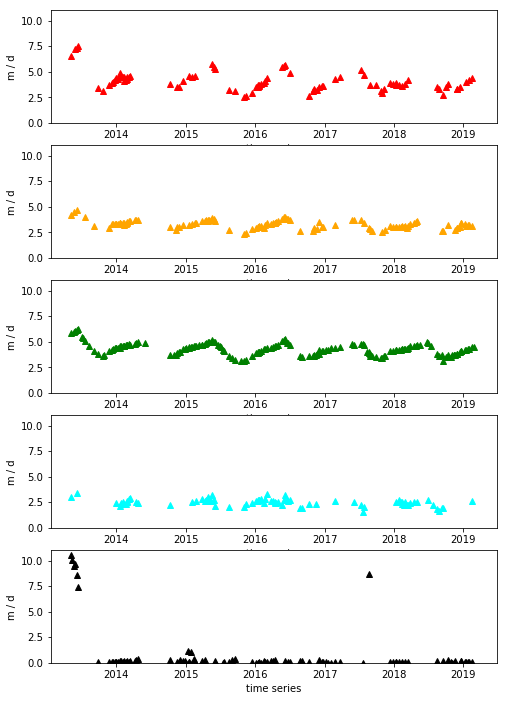

In [45]:
%%time
# Create time-series plots for speeds at the centers of the above four respective lateral transects

# Remember that n16s is how many 16-day-interval results we have; and these are m[0], ..., m[n16s - 1]
timestamps = vv['time']
maxSpeed = 11.
colorsequence = ['red', 'orange', 'green', 'cyan', 'black', 'blue', 'yellow']
fig, axes = plt.subplots(nTransects)
fig.set_size_inches(8,12)
for i in tr_idcs: axes[i].set(ylim=(0., maxSpeed), xlabel='time series', ylabel = 'm / d')

for t in tr_idcs: 
    xMid = utm0[t][0] + (number_of_postings[t]/2.)*relative_postings[t][0]    # These must start at utm0 and add a certain 
    yMid = utm0[t][1] + (number_of_postings[t]/2.)*relative_postings[t][1]    #   number of the relative_postings vectors
    y = vv.sel(y=yMid,x=xMid,method='nearest').values 
    axes[t].plot(timestamps, y, '^', color=colorsequence[t])  
    
# changing the plot type string from triangles '^' to connected triangles '^-' indicates spurious data:
#   -9999 values and errors in speed cause chart lines to dart down / up respectively

In [46]:
# This cell establishes that the lgo_mask varies in time
if False:
    xice = 702
    yice = 402
    for i in range(10):                                          # time slices
        lgoval = lgo.isel(y=yice,x=xice,time=i).values           # most 0 (glacier) but one 1 (land)
        vvval = vv.isel(y=yice,x=xice,time=i).values             # some 'no data' values at -9999.
        corrval = corr.isel(y=yice,x=xice,time=i).values         # ranges .51 to .89
        northval = north.isel(y=yice).values                     # consistent
        eastval = east.isel(x=xice).values                       # consistent
        print(lgoval, vvval, corrval, northval, eastval)

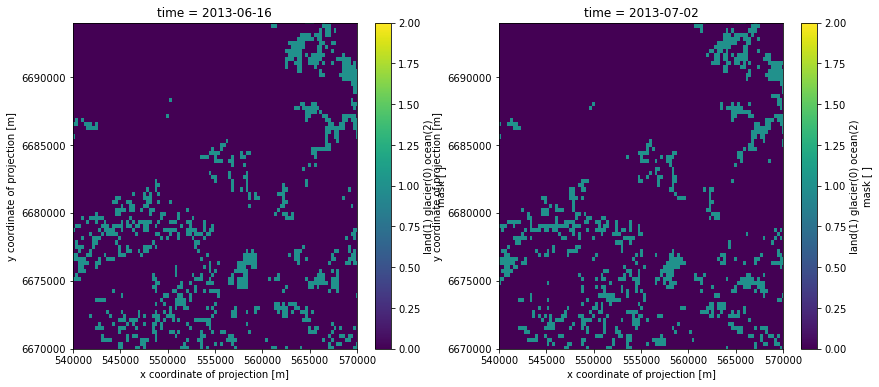

In [47]:
# lgo_mask with consecutive times: Slight differences apparent
# This makes it intrinsically more difficult to settle on a set of for-sure-this-is-moving-ice pixels
if True:
    fig,axes = plt.subplots(1, 2)
    lgo.isel(time=5).plot(ax=axes[0])
    lgo.isel(time=6).plot(ax=axes[1])
    fig.set_size_inches(14,6)
    axes[0].set(xlim=(540000,570000),ylim=(6670000,6694000))
    axes[1].set(xlim=(540000,570000),ylim=(6670000,6694000))

In [48]:
# lgo is a mask of type DataArray. It contains:
#   name = 'lgo_mask'
#   dimensions = time, y, x
#   data (indexed lgo[time][y][x] with values 0, 1, 2 and nan)
#   coordinate DataArrays time, y, x aligned with the dimensions given above
#   attributes (a key-pair dictionary)
print(lgo.time[0].values, '\n\n', lgo[73][450][200:550].values, '\n')
print(lgo)

2013-05-07T00:00:00.000000000 

 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 1. 1. 0. 1. 1. 1.
 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 1. 0.

## Part 3. Entire-scene analysis

* Subsets of DataArrays are DataArrays
  * ...but .data or .values are numpy ndarrays (immutable vectors)
    * 'lists without commas'
* Verify no-data value = -9999. and convert these to nan
* Use xarray.DataArray.mean(dim) and .std(dim) where dim indicates axis of the calculation
  * ...and verify!
* Count how many good data values
* Count lgo 'glacier' values

In [59]:
print(vv.shape)
nTime = vv.shape[0]
print(nTime)

(293, 829, 840)
293


In [50]:
# suppress warnings but better would be to work out the logic and improve the code so as to not get warnings
import warnings
warnings.filterwarnings("ignore",category=RuntimeWarning)

In [53]:
if False: 
    vv.to_netcdf('../data/golive_big/go_speed.nc')     # 800 MB
    lgo.to_netcdf('../data/golive_big/go_lgo.nc')      # 1600 MB

In [1]:
def CompareSnapshotToMean(maxSpeed):
    
    iceThresholdAdHoc = 0.5                            # in what follows: If the mean exceeds this value the pixel is ice
    timeSelectAdHoc = 0
    
    # composition of an lgo mask which is "ice by vote"
    lgo_part1 = lgo.where(lgo.data < 2.)               # lgo mask that is land or glacier; not ocean == 2
    lgo_part2 = lgo_part1.mean('time')                 # now creating 'mean values' for land/glacier pixels between 0 and 1

    # composition of a speed field for a single L8 pair
    vv_snap1 = vv.isel(time=timeSelectAdHoc)                           # using the first in the time series
    vv_snap2 = vv_snap1.where(vv_snap1.data >= 0.)                     #   where speed value exceeds 0. (is therefore not -999)
    vv_snap3 = vv_snap2.where(vv_snap2.data <= 14.)                    #   where speed is less than a maximum of 14 meters per day
    vv_snap4 = vv_snap3.where(lgo_part2.data <= iceThresholdAdHoc)     # where the mask says it is ice
    
    # composition of a time-series mean speed field
    vv_mean1=vv.where(vv.data >= 0.)                                   # data values are not -999 (notice no implicit choice of time yet)
    vv_mean2=vv_mean1.where(vv_mean1.data <= 14.)                      # and speeds are under 14 meters per day
    vv_mean3=vv_mean2.mean('time')                                     # now taken as the mean over the time dimension
    vv_mean4=vv_mean3.where(lgo_part2.data <= iceThresholdAdHoc)       # with the mask applied
    
    fig,axes = plt.subplots(2, 1)
    vv_snap4.plot(ax=axes[0],cmap=plt.cm.rainbow,vmin=0.0, vmax=maxSpeed)
    vv_mean4.plot(ax=axes[1],cmap=plt.cm.rainbow,vmin=0.0, vmax=maxSpeed)
    fig.set_size_inches(14,22)
    axes[0].set(xlim=(480000,570000), ylim=(6630000,6694000))
    axes[1].set(xlim=(480000,570000), ylim=(6630000,6694000))
    
    
interact(CompareSnapshotToMean, maxSpeed=widgets.FloatSlider(min=0.025, max=20., step=.025, \
                                    value=8.0, continuous_update=False, \
                                    readout_format='1.4f', description='max speed'))

NameError: name 'interact' is not defined

In [60]:
def PlotSubregion(speed, a, b, c, d, timeSelect, vMax):
    fig,axes = plt.subplots()
    speed.isel(time=timeSelect).plot(ax=axes,cmap=plt.cm.rainbow,vmin=0.0, vmax=vMax)
    fig.set_size_inches(14,8)
    # axes.set(xlim=(a,c), ylim=(b,d))

def go(timeSelector, vMax): 
    a,c,b,d = 480000,570000,6630000,6694000
    PlotSubregion(vv, a, b, c, d, timeSelector, vMax)
    
interact(go, timeSelector=widgets.IntSlider(min=0,max=nTime-1,step=1,value=0, continuous_update=False, description='image index'),       
             vMax=widgets.FloatSlider(min=0.05, max=20., step=.025, value=8.0, continuous_update=False, \
                                      readout_format='1.4f', description='max speed'))

interactive(children=(IntSlider(value=0, continuous_update=False, description='image index', max=292), FloatSl…

<function __main__.go(timeSelector, vMax)>

In [57]:
# short digression on using nan (not-a-number)
a=float('nan')
print(a)
print(a+a)
print(np.isnan(a))

nan
nan
True


In [74]:
# This cell is as the one above but with two criteria applied to 'vv'
vv_nonneg = vv.where(vv.data >= 0.)
vv_0to20  = vv_nonneg.where(vv1.data < 20.)

print(vv_0to20.shape)
# and lgo.data.any('time')<1.0)

def go(timeSelector, vMax): 
    a,c,b,d = 480000,570000,6630000,6694000
    PlotSubregion(vv_0to20, a, b, c, d, timeSelector, vMax)
    
interact(go, timeSelector=widgets.IntSlider(min=0,max=nTime-1,step=1,value=0, continuous_update=False, \
                                            description='image index'),       
             vMax=widgets.FloatSlider(min=0.05, max=20., step=.025, value=8.0, continuous_update=False, \
                                      readout_format='1.4f', description='max speed'))

(293, 829, 840)


interactive(children=(IntSlider(value=0, continuous_update=False, description='image index', max=292), FloatSl…

<function __main__.go(timeSelector, vMax)>

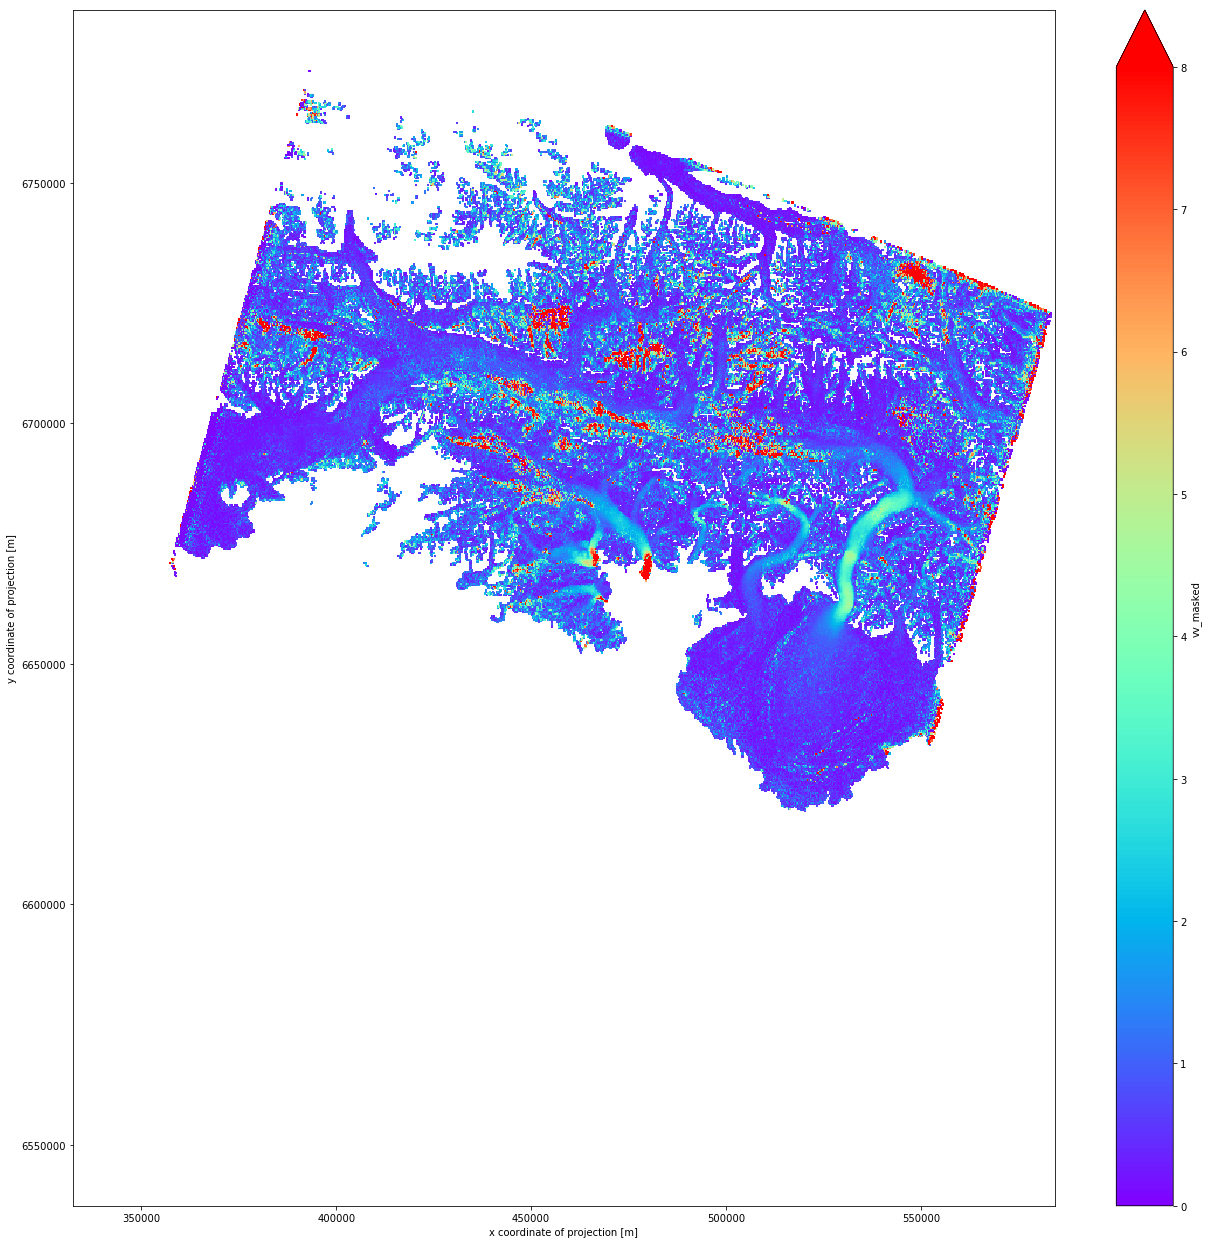

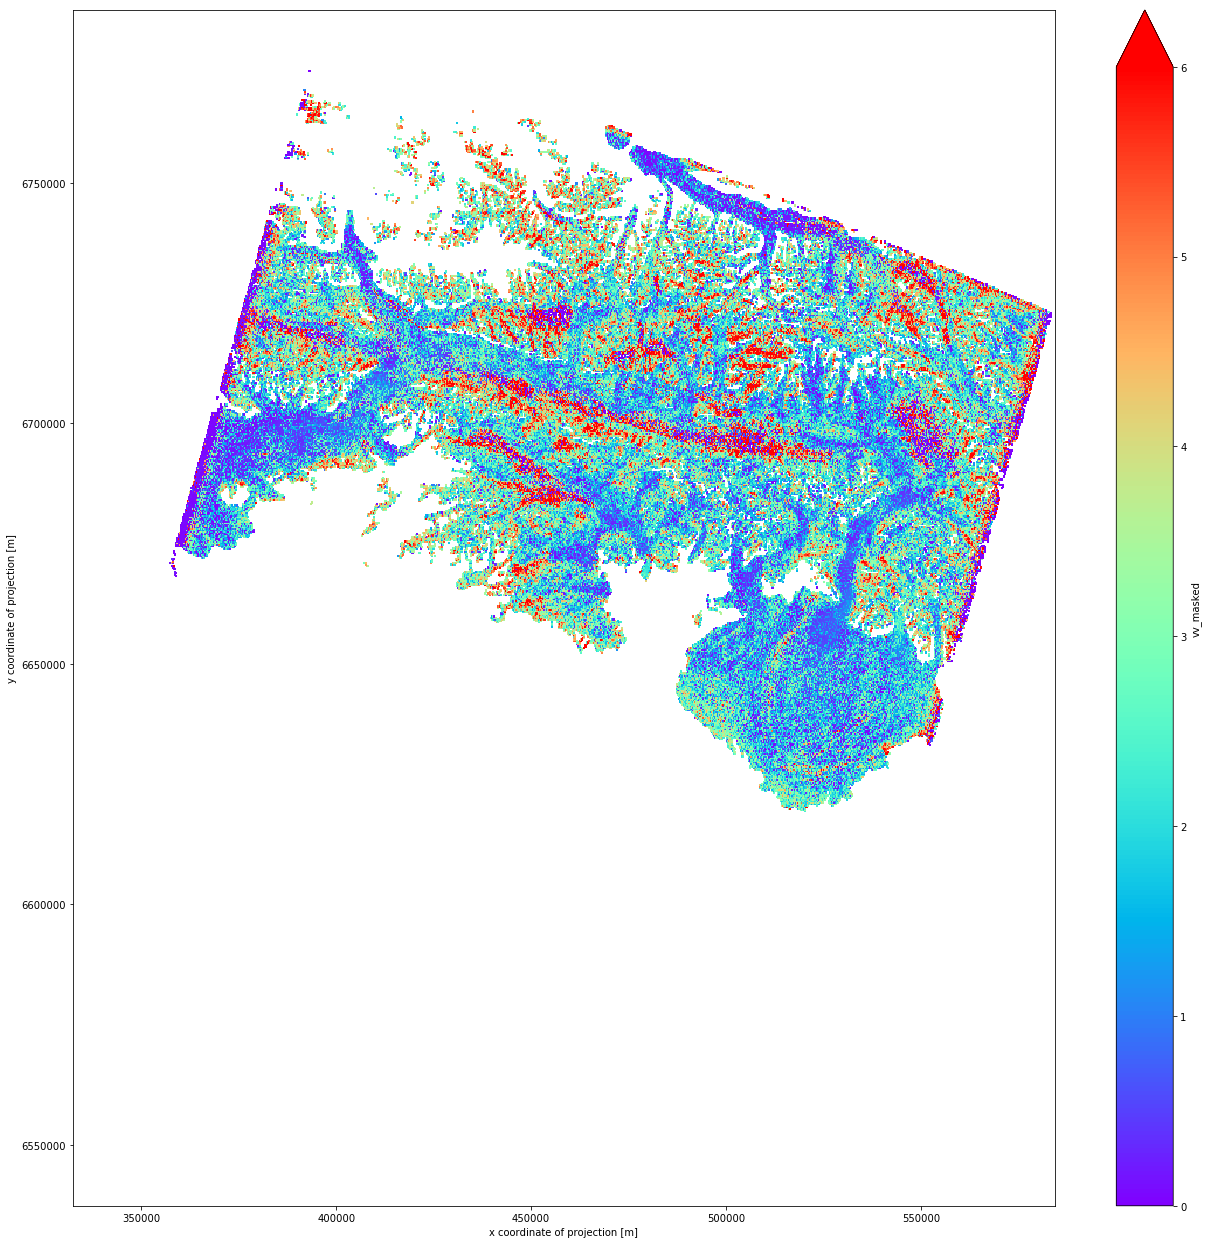

In [96]:
# As above but without the selector widgets for scale and for obvious reasons for choice of 
#   frame: These are mean and standard deviation views of ice speed.

def PlotSubregionNoTime(speed, a, b, c, d, vMax):
    fig,axes = plt.subplots()
    speed.plot(ax=axes,cmap=plt.cm.rainbow,vmin=0.0, vmax=vMax)
    fig.set_size_inches(22,22)
    # axes.set(xlim=(a,c), ylim=(b,d))
  
lgo_step1 = lgo.where(lgo.data < 2.)               # lgo mask that is land or glacier; not ocean == 2
lgo_step2 = lgo_step1.mean('time')                 # now creating 'mean values' for land/glacier pixels between 0 and 1

iceThresholdAdHoc = 0.5

vv_lgo_applied = vv_0to20.where(lgo_step2.data <= iceThresholdAdHoc)
vv_mean = vv_lgo_applied.mean('time')
vv_std  = vv_lgo_applied.std('time')

a,c,b,d = 480000,570000,6630000,6694000

PlotSubregionNoTime(vv_mean, a, b, c, d, 8.)
PlotSubregionNoTime(vv_std,  a, b, c, d, 6.)


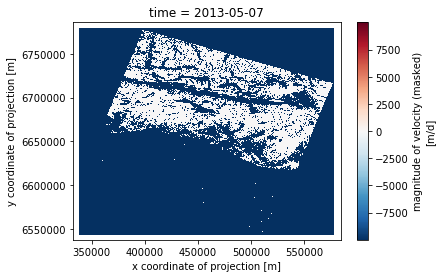

In [72]:
vv.isel(time=0).plot()        # As -9999 values are not filtered this looks like a mask

In [85]:
# a simple check on 
print(vv_0to20.isel(x=537,y=319).mean('time').data)

0.07940354


(6630000, 6730000)

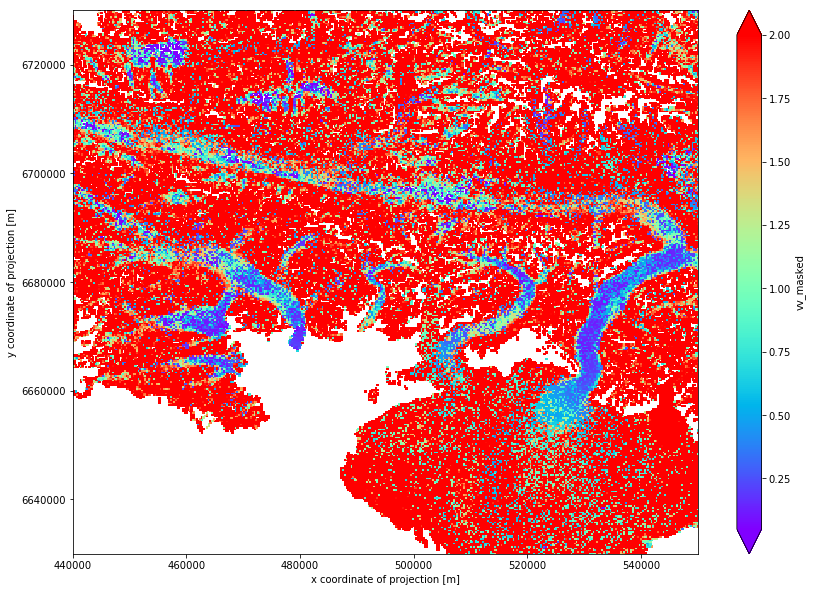

In [88]:
vv_coeff_of_variation=vv_std/vv_mean
vv_coeff_of_variation.shape
vv_coeff_of_variation.plot(figsize=(14,10),cmap=plt.cm.rainbow,vmin=0.05, vmax=2.0)
plt.xlim(440000,550000)
plt.ylim(6630000,6730000)

In [92]:
vv_cov1 = vv_coeff_of_variation.where(vv_coeff_of_variation.data < 2.0)
vv_cov2 = vv_cov1.where(vv_cov1.data > 0.05)


(6630000, 6730000)

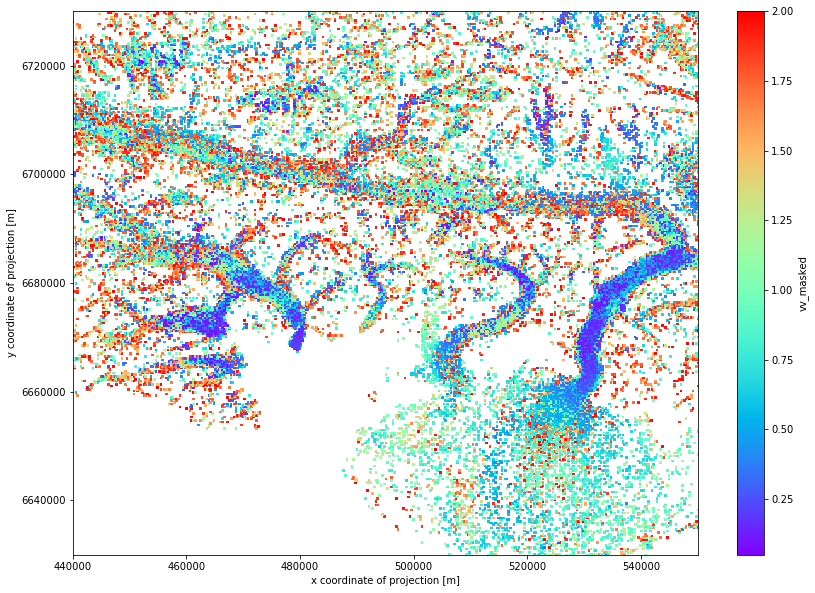

In [94]:
vv_cov3 = vv_cov2.where(lgo_step2.data < 0.5)
vv_cov3.plot(figsize=(14,10),cmap=plt.cm.rainbow,vmin=0.05, vmax=2.0)
plt.xlim(440000,550000)
plt.ylim(6630000,6730000)

### Conclusions



Inspection of time-series speeds on Seward glacier for the 5.4 year time period considered 
here shows modest annual variability consistent with
glaciers accelerating in spring as melt water facilitates sliding. 


<img src="seward_timeseries.png" alt="drawing" width="500"/>


A surge is apparent in late spring 2013 on the glacier just 
east of Seward: 10 meters per day in late spring 2013.



<img src="surge_timeseries.png" alt="drawing" width="500"/>

